[Implementation from this tutorial](https://medium.com/@nubyra/parameter-efficient-fine-tuning-peft-of-bert-base-model-to-predict-medical-diagnosis-5086a1828f4b)

In [1]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding, 
    Trainer, 
    TrainingArguments, 
    pipeline
)
from peft import (
    PeftModel, 
    PeftConfig, 
    LoraConfig, 
    TaskType, 
    get_peft_model
)
import torch
import pandas as pd
import numpy as np
import os

In [2]:
model_name = "allegro/herbert-base-cased"
device = "mps"

In [3]:
data_path = "all_texts.csv"
df = pd.read_csv(data_path)

# Check the data
print("First few entries:")
df.head()

First few entries:


,text,label
0,"Lakier roweru bardzo kiepskiej jakości , robią...",Negative
1,Nie jestem zadowolony z zakupu . Przede wszyst...,Negative
2,Szukając klucze tej wielkości brał em dwa pod ...,Neutral
3,Długo szukała m odpowiedniego fotelika dla bar...,Neutral
4,Kupił em pociąg ( w zestawie kilka torów prost...,Negative


In [4]:
# Determine the number of samples per class
class_counts = df['label'].value_counts()
print("\nClass Counts:")
print(class_counts)

# Find the minimum class count
min_count = class_counts.min()
print(f"\nMinimum class count: {min_count}")


Class Counts:
label
Neutral     150
Positive     83
Negative     67
Name: count, dtype: int64

Minimum class count: 67


In [5]:
# Set a random seed for reproducibility
random_seed = 42

# Undersample each class to have `min_count` samples
df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)

# Verify the new distribution
print("\nBalanced Label Distribution:")
print(df_balanced['label'].value_counts(normalize=True) * 100)


Balanced Label Distribution:
label
Negative    33.333333
Neutral     33.333333
Positive    33.333333
Name: proportion, dtype: float64


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_70250/3664909914.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)


In [6]:
train_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    random_state=42, 
    # stratify=df['label']
)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 41
    })
})

In [7]:
print("Unique Labels:", sorted(df['label'].unique()))
print("Number of Labels:", len(sorted(df['label'].unique())))
# Label distribution in training set
print("Training Set Label Distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

# Label distribution in test set
print("\nTest Set Label Distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)      # 41.46341463414634

Unique Labels: ['Negative', 'Neutral', 'Positive']
Number of Labels: 3
Training Set Label Distribution:
label
Negative    35.00
Positive    33.75
Neutral     31.25
Name: proportion, dtype: float64

Test Set Label Distribution:
label
Neutral     41.463415
Positive    31.707317
Negative    26.829268
Name: proportion, dtype: float64


In [8]:
for entry in dataset['train'].select(range(3)):
    print('INPUT: {} \nOUTPUT: {}\n'.format(entry['text'], entry['label']))

INPUT: Duza częśc grupy zaliczyła w kolokwiach . 
OUTPUT: Positive

INPUT: Klawiaturę otrzymał em , rozpakował em , podłączył em , zainstalował em soft pobrany ze strony Razer . Windows 7 widzi klawiaturę poprawnie i instaluje ją gładko . Niestety oprogramowanie Razer nie rozpoznaje własnej klawiatury . Nie pomaga przepinanie do innych portów USB , wielokrotny restart , ani odpięcie innych urządzeń USB od komputera . W dodatku soft jest zaprojektowany tak bezmyślnie , że dopóki nie wykryje klawiatury , nie można nawet kliknąć ikony pomocy , przeczytać dokumentacji ani zrobić nic innego . Bez tego oprogramowania nie można skonfigurować dodatkowych klawiszy ani korzystać z żadnych innych funkcji klawiatury . Gdyby m mógł tej klawiatury używać , narzekał by m na zbyt twarde klawisze i na to , że między obudową a dolnymi klawiszami mini - padu ( który sam w sobie jest genialnym pomysłem , nie tylko do gier ! ) zieje szeroka szczelina , przez którą widać płytkę drukowaną pod spodem . Takie 

In [9]:
# Analyze label distribution
train_counts = pd.DataFrame({'Diagnosis': train_df['label']})
train_counts = train_counts.groupby('Diagnosis').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Diagnosis': test_df['label']})
test_counts = test_counts.groupby('Diagnosis').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Diagnosis'))

,Diagnosis,train_set,test_set
0,Negative,56,11
1,Neutral,50,17
2,Positive,54,13


In [10]:
sorted_labels = sorted(set(df['label']))
label2id = {label: idx for idx, label in enumerate(sorted_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
ID to Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [11]:

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained model for sequence classification
foundation_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

classifier = pipeline("text-classification", model=foundation_model, tokenizer=tokenizer, device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Evaluate the foundation model before fine-tuning
print("Evaluating foundation model before fine-tuning...")

# Tokenize test inputs
test_encodings = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

foundation_model.to(device)
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

with torch.no_grad():
    outputs = foundation_model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Calculate accuracy
test_labels = test_df['label'].map(label2id).values
foundation_accuracy = round(np.mean(predictions == test_labels) * 100, 2)
print(f"Foundation Model Accuracy: {foundation_accuracy}%")

Evaluating foundation model before fine-tuning...
Foundation Model Accuracy: 29.27%


In [13]:
print("Number of Labels in Model:", foundation_model.config.num_labels)

Number of Labels in Model: 3


In [14]:
# Set up LoRA configuration for PEFT
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=64, 
    lora_alpha=1, 
    lora_dropout=0.1
)

peft_model = get_peft_model(foundation_model, lora_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [15]:
peft_model.print_trainable_parameters()

trainable params: 2,361,603 || all params: 126,806,790 || trainable%: 1.8624


In [16]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

# Apply preprocessing with removal of the original 'label' column
tokenized_ds = dataset.map(preprocess_function, batched=True, remove_columns=["label"])

print(tokenized_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 41
    })
})


In [17]:
print("A tokenized training input example:")
# text
print(tokenized_ds["train"][0]["text"])
# tokens
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["labels"])

A tokenized training input example:
Duza częśc grupy zaliczyła w kolokwiach .
[0, 3491, 2163, 2300, 49518, 4106, 11295, 4061, 1019, 6167, 3680, 2207, 1899, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean() * 100
    return {"accuracy": accuracy}

# Set up Trainer
trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(
        output_dir="herbert-lora",
        learning_rate=2e-5,  # Reduced learning rate for better fine-tuning
        per_device_train_batch_size=8,  # Adjust based on your GPU memory
        per_device_eval_batch_size=8,
        num_train_epochs=15,  # Adjust number of epochs as needed
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 1.0977, 'grad_norm': 8.038151741027832, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.5}
{'loss': 1.1097, 'grad_norm': 7.334142684936523, 'learning_rate': 1.866666666666667e-05, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1145750284194946, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 3.0808, 'eval_samples_per_second': 13.308, 'eval_steps_per_second': 1.948, 'epoch': 1.0}
{'loss': 1.0931, 'grad_norm': 4.726180076599121, 'learning_rate': 1.8e-05, 'epoch': 1.5}
{'loss': 1.1174, 'grad_norm': 6.743591785430908, 'learning_rate': 1.7333333333333336e-05, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1145315170288086, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.06, 'eval_samples_per_second': 19.903, 'eval_steps_per_second': 2.913, 'epoch': 2.0}
{'loss': 1.1235, 'grad_norm': 5.9114484786987305, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.5}
{'loss': 1.1021, 'grad_norm': 2.1796929836273193, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1114311218261719, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0869, 'eval_samples_per_second': 19.646, 'eval_steps_per_second': 2.875, 'epoch': 3.0}
{'loss': 1.1024, 'grad_norm': 3.3069138526916504, 'learning_rate': 1.5333333333333334e-05, 'epoch': 3.5}
{'loss': 1.1071, 'grad_norm': 9.022171020507812, 'learning_rate': 1.4666666666666666e-05, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1092479228973389, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0967, 'eval_samples_per_second': 19.554, 'eval_steps_per_second': 2.862, 'epoch': 4.0}
{'loss': 1.1072, 'grad_norm': 4.479854106903076, 'learning_rate': 1.4e-05, 'epoch': 4.5}
{'loss': 1.1134, 'grad_norm': 9.349715232849121, 'learning_rate': 1.3333333333333333e-05, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.108566403388977, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.3015, 'eval_samples_per_second': 17.814, 'eval_steps_per_second': 2.607, 'epoch': 5.0}
{'loss': 1.108, 'grad_norm': 3.1446948051452637, 'learning_rate': 1.2666666666666667e-05, 'epoch': 5.5}
{'loss': 1.1059, 'grad_norm': 6.404232025146484, 'learning_rate': 1.2e-05, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.107526421546936, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.2814, 'eval_samples_per_second': 17.972, 'eval_steps_per_second': 2.63, 'epoch': 6.0}
{'loss': 1.0878, 'grad_norm': 3.2521848678588867, 'learning_rate': 1.1333333333333334e-05, 'epoch': 6.5}
{'loss': 1.0878, 'grad_norm': 4.290170192718506, 'learning_rate': 1.0666666666666667e-05, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.107470154762268, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.1493, 'eval_samples_per_second': 19.076, 'eval_steps_per_second': 2.792, 'epoch': 7.0}
{'loss': 1.0969, 'grad_norm': 4.0294060707092285, 'learning_rate': 1e-05, 'epoch': 7.5}
{'loss': 1.0746, 'grad_norm': 6.737278461456299, 'learning_rate': 9.333333333333334e-06, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1066749095916748, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0354, 'eval_samples_per_second': 20.143, 'eval_steps_per_second': 2.948, 'epoch': 8.0}
{'loss': 1.0812, 'grad_norm': 4.5443315505981445, 'learning_rate': 8.666666666666668e-06, 'epoch': 8.5}
{'loss': 1.1059, 'grad_norm': 6.583975791931152, 'learning_rate': 8.000000000000001e-06, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.106225848197937, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.2882, 'eval_samples_per_second': 17.918, 'eval_steps_per_second': 2.622, 'epoch': 9.0}
{'loss': 1.1022, 'grad_norm': 2.8471648693084717, 'learning_rate': 7.333333333333333e-06, 'epoch': 9.5}
{'loss': 1.0954, 'grad_norm': 7.145320415496826, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.106073260307312, 'eval_accuracy': 29.268292682926827, 'eval_runtime': 2.0384, 'eval_samples_per_second': 20.114, 'eval_steps_per_second': 2.943, 'epoch': 10.0}
{'loss': 1.088, 'grad_norm': 2.246035575866699, 'learning_rate': 6e-06, 'epoch': 10.5}


In [ ]:
peft_herbert_model_path = "fine-tuned-peft-herbert-model-weights/"
peft_model.save_pretrained(peft_herbert_model_path)

# Check the size of the saved model
for file_name in os.listdir(peft_herbert_model_path):
    file_size = os.path.getsize(os.path.join(peft_herbert_model_path, file_name))
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: adapter_model.safetensors; File Size: 9231.85KB
File Name: README.md; File Size: 4.98KB
File Name: adapter_config.json; File Size: 0.66KB


In [ ]:
# Evaluate the fine-tuned model
print("Evaluating fine-tuned model...")

# Load the PEFT model for evaluation
config = PeftConfig.from_pretrained(peft_herbert_model_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
model = PeftModel.from_pretrained(model, peft_herbert_model_path)

# Move model to appropriate device
model.to(device)

# Set up a new Trainer for evaluation
eval_trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="allegro-bert-lora",
        learning_rate=2e-5,  # Reduced learning rate for better fine-tuning
        per_device_train_batch_size=8,  # Adjust based on your GPU memory
        per_device_eval_batch_size=8,
        num_train_epochs=3,  # Adjust number of epochs as needed
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
        
    ),
    eval_dataset=tokenized_ds['test'],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Predict and evaluate
test_results = eval_trainer.evaluate()
print(test_results)

# %%
# Save the final model (optional)
model_save_path = "final-fine-tuned-peft-herbert-model/"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

Evaluating fine-tuned model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1133830547332764, 'eval_model_preparation_time': 0.0024, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 3.5498, 'eval_samples_per_second': 11.55, 'eval_steps_per_second': 1.69}


('final-fine-tuned-peft-herbert-model/tokenizer_config.json',
 'final-fine-tuned-peft-herbert-model/special_tokens_map.json',
 'final-fine-tuned-peft-herbert-model/vocab.json',
 'final-fine-tuned-peft-herbert-model/merges.txt',
 'final-fine-tuned-peft-herbert-model/added_tokens.json',
 'final-fine-tuned-peft-herbert-model/tokenizer.json')

In [ ]:
# Evaluate the model on the test set and get predictions
predictions_output = trainer.predict(tokenized_ds["test"])

# Extract predicted labels and true labels
preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Map label IDs back to label names
predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Initialize the data collator with your tokenizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the DataLoader with the collate_fn
test_loader = DataLoader(
    tokenized_ds["test"],
    batch_size=16,  # Adjust based on your GPU memory
    shuffle=False,
    collate_fn=data_collator
)

In [ ]:
# Use the Trainer's predict method
predictions_output = eval_trainer.predict(tokenized_ds["test"])

# Extract predicted label IDs and true label IDs
preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Map label IDs back to label names
predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_41208/3423536581.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




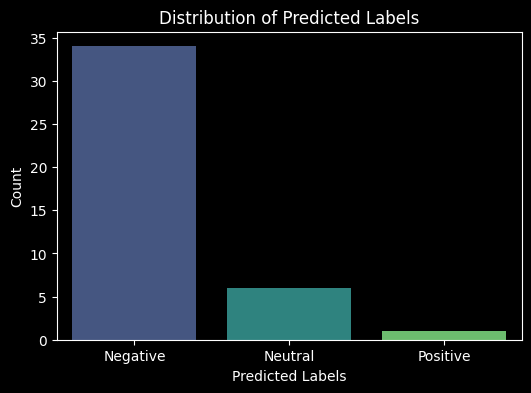

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Count the frequency of each predicted label
pred_label_counts = pd.Series(predicted_labels).value_counts()

# Plot the distribution
plt.figure(figsize=(6,4))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()

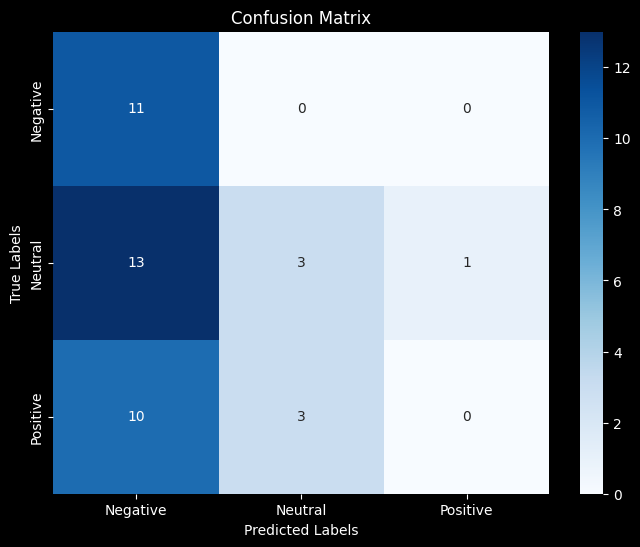

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

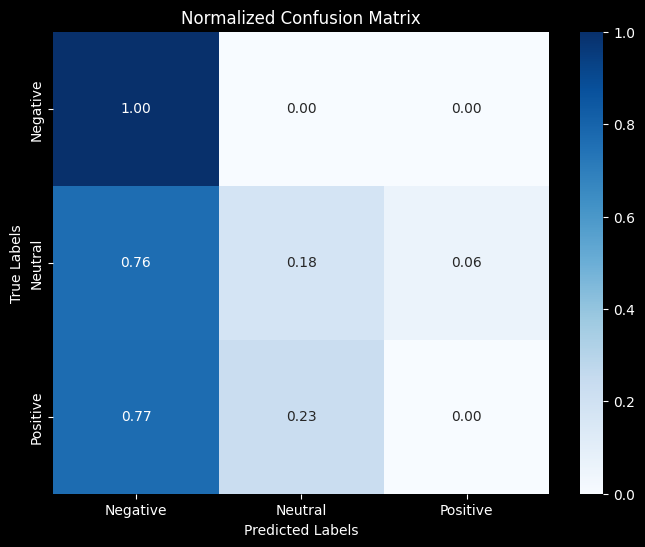

In [ ]:
# Normalize the confusion matrix by true labels (rows)
cm_normalized = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=sorted_labels)
print(report)

              precision    recall  f1-score   support

    Negative       0.32      1.00      0.49        11
     Neutral       0.50      0.18      0.26        17
    Positive       0.00      0.00      0.00        13

    accuracy                           0.34        41
   macro avg       0.27      0.39      0.25        41
weighted avg       0.29      0.34      0.24        41



In [ ]:
import torch.nn.functional as F

# Function to get probabilities
def get_probabilities(logits):
    return F.softmax(torch.tensor(logits), dim=-1).numpy()

# Get probabilities for each prediction
probabilities = get_probabilities(predictions_output.predictions)

# Example: Display probabilities for the first 5 test samples
for i in range(5):
    print(f"Example {i+1}:")
    print(f"Text: {test_df['text'].iloc[i]}")
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Probabilities: {probabilities[i]}")
    print("-" * 50)

Example 1:
Text: Jesli sluchasz go na zajeciach i zrobisz w domu ze 2 zadanka , to powinienes bez problemow zaliczyc .
True Label: Neutral
Predicted Label: Neutral
Probabilities: [0.34358478 0.3562779  0.30013737]
--------------------------------------------------
Example 2:
Text: Gdy je poprawiasz i przynosisz następnym razem , wyszukuje Ci kolejne błedy , a to co poprawił eś na dobrze , jest źle i miało być tak jak na poczatku .
True Label: Negative
Predicted Label: Negative
Probabilities: [0.3628571  0.34553397 0.29160893]
--------------------------------------------------
Example 3:
Text: UWAGA !
True Label: Negative
Predicted Label: Negative
Probabilities: [0.34457517 0.31537953 0.34004533]
--------------------------------------------------
Example 4:
Text: Z zaliczeniem nie ma raczej problemu .
True Label: Positive
Predicted Label: Negative
Probabilities: [0.38236794 0.34888235 0.26874968]
--------------------------------------------------
Example 5:
Text: Mało wytłumaczy , ale c

In [ ]:
# %%
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
from tqdm import tqdm

def preprocess_function(examples):
    tokens = tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512  # Adjust max_length as needed
    )
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

# Remove all original columns during tokenization
tokenized_ds = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=dataset["train"].column_names  # This removes 'text', 'label', and any other original columns
)

print(tokenized_ds)


# Funkcja do ekstrakcji wektorów reprezentacji [CLS]
def extract_embeddings(model, tokenizer, dataset, device, batch_size=16):
    model.eval()
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    embeddings = []
    labels = []
    
    model_input_keys = tokenizer.model_input_names  # Zazwyczaj ['input_ids', 'attention_mask', 'token_type_ids']

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            # Przygotowanie wejść
            inputs = {k: v.to(device) for k, v in batch.items() if k in model_input_keys}
            # Wywołanie modelu z output_hidden_states=True
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            # Ukryte stany to krotka wszystkich warstw
            hidden_states = outputs.hidden_states
            # Pobranie ostatniego ukrytego stanu
            last_hidden_state = hidden_states[-1]  # Kształt: [batch_size, seq_length, hidden_size]
            # Wyodrębnienie reprezentacji [CLS]
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
            labels.extend(batch['labels'].cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    return embeddings, labels

# %%
# Ekstrakcja wektorów reprezentacji dla zbioru testowego
test_embeddings, test_labels_ids = extract_embeddings(
    model, 
    tokenizer, 
    tokenized_ds["test"], 
    device=device, 
    batch_size=16
)

# Mapowanie ID etykiet na nazwy
test_labels = [id2label[label_id] for label_id in test_labels_ids]

# Opcjonalnie, jeśli chcesz również dodać przewidywane etykiety
test_predicted_labels = [id2label[pred] for pred in preds]


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 41
    })
})


Extracting embeddings: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


In [ ]:

pca = PCA(n_components=40, random_state=42)
embeddings_pca = pca.fit_transform(test_embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

df_visualization = pd.DataFrame({
    'TSNE-1': embeddings_tsne[:,0],
    'TSNE-2': embeddings_tsne[:,1],
    'True Label': test_labels,
    'Predicted Label': test_predicted_labels
})

fig_true = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='True Label',
    hover_data=['True Label', 'Predicted Label'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Prawdziwe Etykiety)',
    width=800,
    height=600
)

fig_true.show()

fig_pred = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Predicted Label',
    hover_data=['True Label', 'Predicted Label'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Przewidywane Etykiety)',
    width=800,
    height=600
)

fig_pred.show()

df_visualization['Correct'] = df_visualization['True Label'] == df_visualization['Predicted Label']

fig_correct = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Correct',
    symbol='Correct',
    hover_data=['True Label', 'Predicted Label'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Zaznaczenie Poprawnych/Niepoprawnych)',
    width=800,
    height=600
)

fig_correct.show()

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
